# **Energy Consumption Forecasting: Time Series vs. Advanced Models**

## Dataset Overview

The Energy Consumption dataset contains experimental data for energy usage in a low-energy building, focusing on the energy consumption of various household appliances. The dataset consists of 19,735 records and 29 attributes, with the target variable being the energy consumption (in Wh) of the appliances. It includes measurements such as temperature, humidity, and energy use across various rooms in the building, as well as weather data from the nearby Chievres weather station.

The project aims to model appliance energy consumption using time series data, incorporating environmental factors like temperature and humidity from different rooms and external weather conditions. This dataset will be used for time series forecasting, with an emphasis on evaluating different regression models, including advanced models like XGBoost, and comparing them to traditional time series approaches like SARIMA.

[Dataset Link](https://www.kaggle.com/datasets/sohommajumder21/appliances-energy-prediction-data-set)

## **Data Inspection and Preparation**

Before we import and analyse our dataset, let's first create a cell fully dedicated to importing requirements

In [6]:
import pandas as pd
import numpy as np
import datetime
import itertools
import warnings
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.subplots as sp

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import scipy.stats as stats

from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    mean_absolute_percentage_error, 
    r2_score
)
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.feature_selection import SelectKBest, f_regression

from tsfresh import extract_features
from tsfresh.feature_extraction import settings, EfficientFCParameters, MinimalFCParameters
from tsfresh.utilities.dataframe_functions import impute

import xgboost as xgb

In [7]:
df = pd.read_csv(r"C:\Users\user\Desktop\energydata_complete.csv")
df.head().T

,0,1,2,3,4
date,11-01-2016 17:00,11-01-2016 17:10,11-01-2016 17:20,11-01-2016 17:30,11-01-2016 17:40
Appliances,60,60,50,50,60
lights,30,30,30,40,40
T1,19.89,19.89,19.89,19.89,19.89
RH_1,47.596667,46.693333,46.3,46.066667,46.333333
T2,19.2,19.2,19.2,19.2,19.2
RH_2,44.79,44.7225,44.626667,44.59,44.53
T3,19.79,19.79,19.79,19.79,19.79
RH_3,44.73,44.79,44.933333,45.0,45.0
T4,19.0,19.0,18.926667,18.89,18.89


So here below is a brief info about all the variables we have:
- date time year-month-day hour:minute:second
- Appliances, energy use in Wh (target variable for prediction)
- lights, energy use of light fixtures in the house in Wh
- T1, Temperature in kitchen area, in Celsius
- RH_1, Humidity in kitchen area, in %
- T2, Temperature in living room area, in Celsius
- RH_2, Humidity in living room area, in %
- T3, Temperature in laundry room area
- RH_3, Humidity in laundry room area, in %
- T4, Temperature in office room, in Celsius
- RH_4, Humidity in office room, in %
- T5, Temperature in bathroom, in Celsius
- RH_5, Humidity in bathroom, in %
- T6, Temperature outside the building (north side), in Celsius
- RH_6, Humidity outside the building (north side), in %
- T7, Temperature in ironing room , in Celsius
- RH_7, Humidity in ironing room, in %
- T8, Temperature in teenager room 2, in Celsius
- RH_8, Humidity in teenager room 2, in %
- T9, Temperature in parents room, in Celsius
- RH_9, Humidity in parents room, in %
- To, Temperature outside (from Chievres weather station), in Celsius
- Pressure (from Chievres weather station), in mm Hg
- RH_out, Humidity outside (from Chievres weather station), in %
- Wind speed (from Chievres weather station), in m/s
- Visibility (from Chievres weather station), in km
- Tdewpoint (from Chievres weather station), Â°C
- rv1, Random variable 1, nondimensional
- rv2, Random variable 2, nondimensional


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [10]:
df.isnull().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

In [11]:
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M')
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_week'] = df['date'].dt.dayofweek

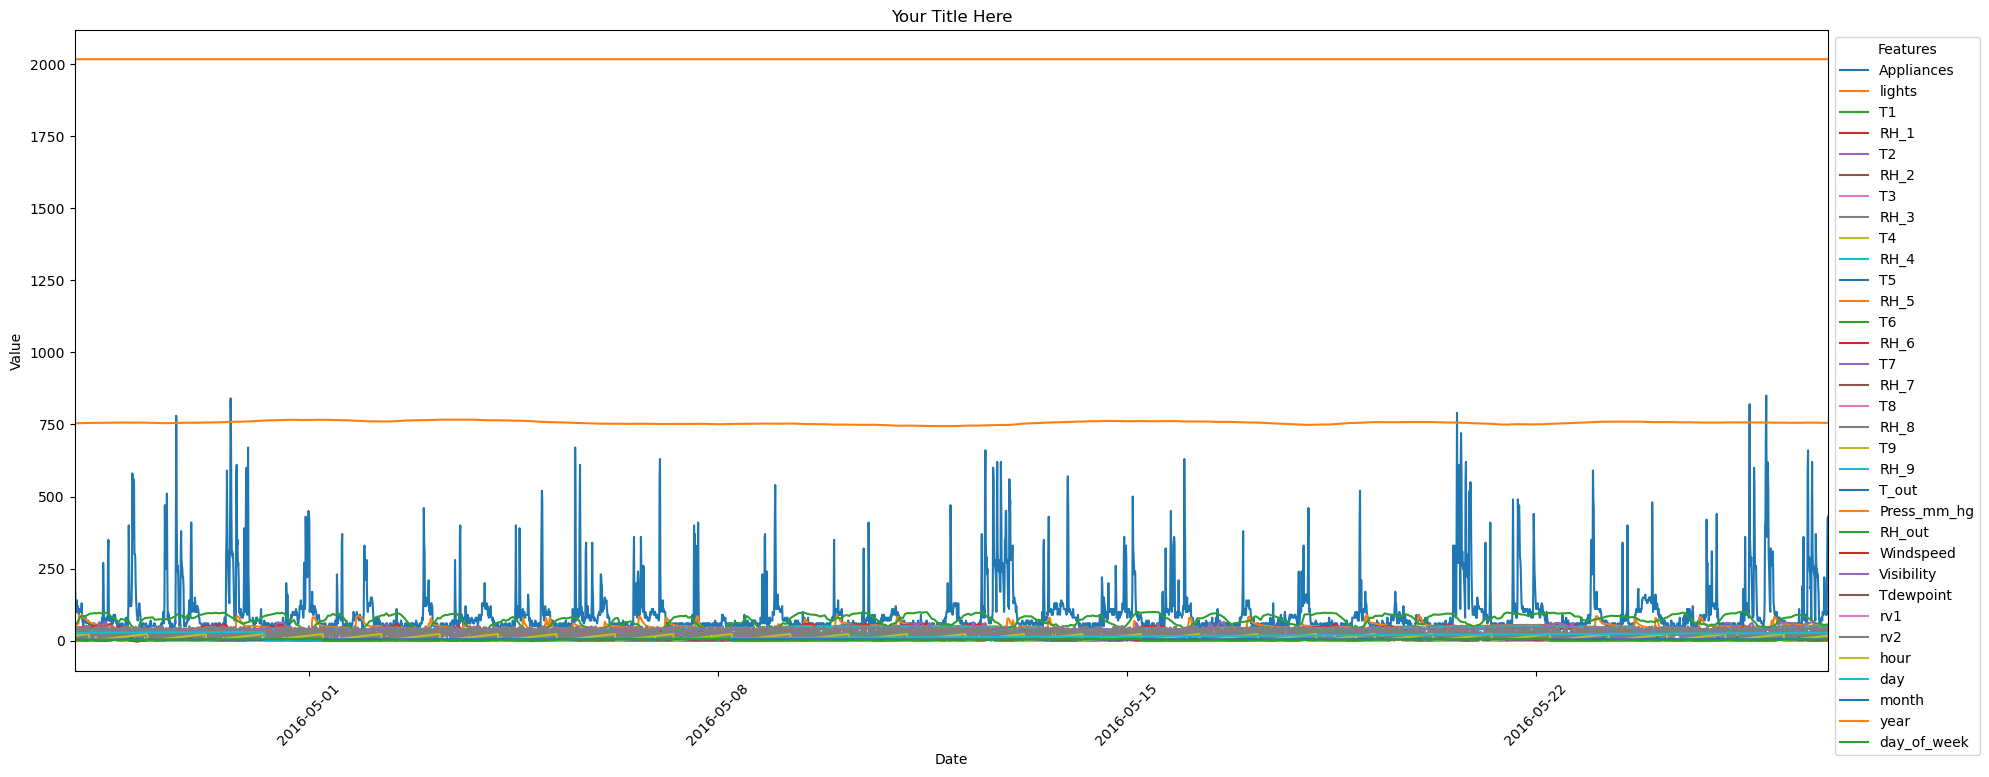

In [12]:
plt.figure(figsize=(20, 8))

df['date'] = pd.to_datetime(df['date'])

last_month = df['date'].max() - pd.DateOffset(months=1)
df_last_month = df[df['date'] >= last_month]

for column in df_last_month.columns[1:]:
    plt.plot(df_last_month['date'], df_last_month[column], label=column)

plt.title('Your Title Here')
plt.xlabel('Date')
plt.ylabel('Value')

plt.xticks(pd.date_range(start=df_last_month['date'].min(), end=df_last_month['date'].max(), freq='W'), rotation=45)

plt.xlim(df_last_month['date'].min(), df_last_month['date'].max())

plt.legend(title='Features', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.show()

This plot doesn't tell much of a story, but it gives us some ideas about the variables and their series. All fo them seem to have pretty stable stationarity, with no trend and fixed seasonalities, which is pretty obvious because the temperature, pressure, humidity and this kind of variables are dependent on seasons of the year (as well as day and night period), so does the energy usage, which I will explore more deeply soon

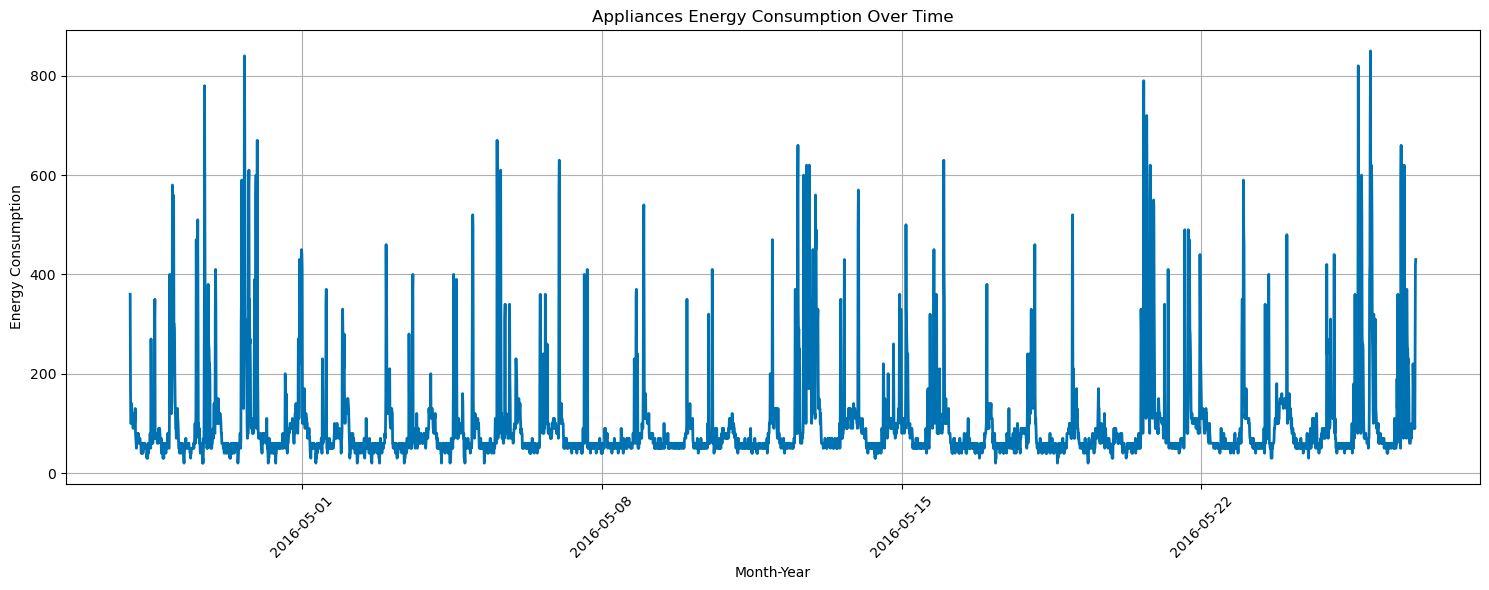

In [14]:
plt.figure(figsize=(15, 6))

df['date'] = pd.to_datetime(df['date'])

last_month = df['date'].max() - pd.DateOffset(months=1)
df_last_month = df[df['date'] >= last_month]

plt.plot(df_last_month['date'], df_last_month['Appliances'], color='#0072B2', linewidth=2)

plt.title('Appliances Energy Consumption Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Energy Consumption')

plt.xticks(pd.date_range(start=df_last_month['date'].min(), end=df_last_month['date'].max(), freq='W'), rotation=45)

plt.grid(True)
plt.tight_layout()

plt.show()

As I mentioned, our target variable seems to have a significant seasonality, which is pretty self explanatory

Now I will do some bivariate and multivariate analysis, to find out relationships and dependencies between target and independent variables

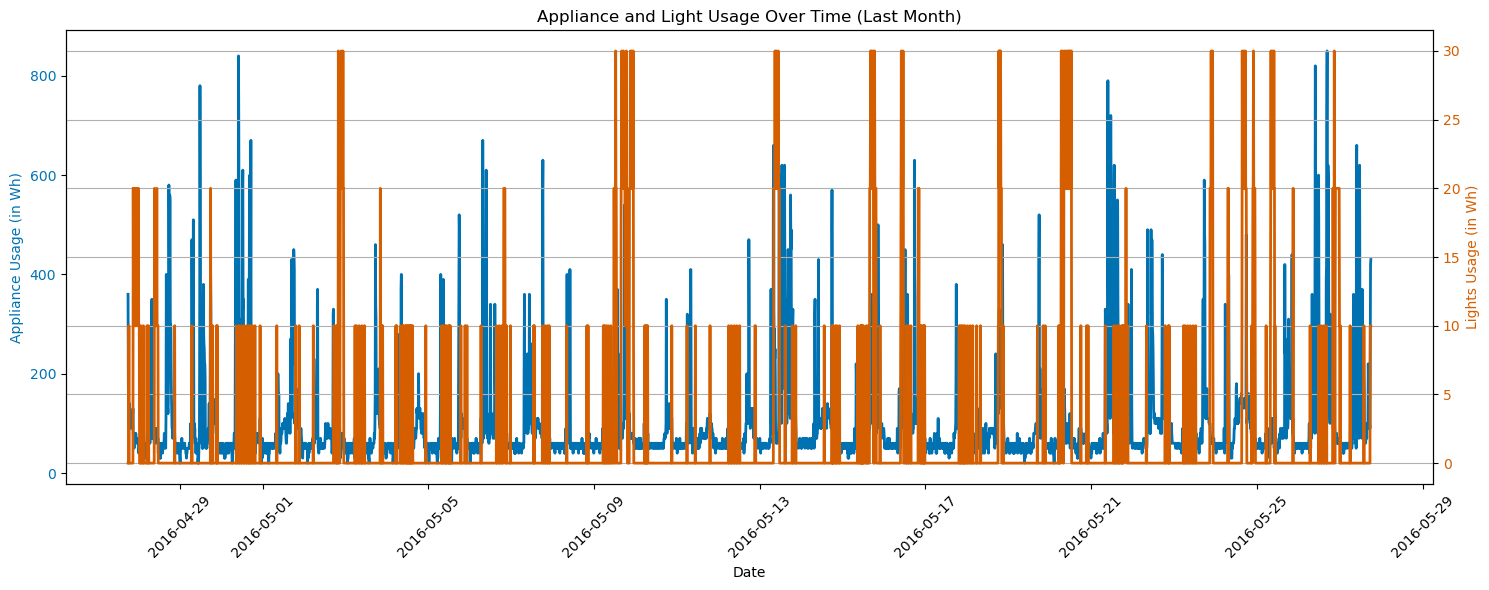

In [17]:
fig, ax1 = plt.subplots(figsize=(15, 6))

df['date'] = pd.to_datetime(df['date'])

last_month = df['date'].max() - pd.DateOffset(months=1)
df_last_month = df[df['date'] >= last_month]

ax1.plot(df_last_month['date'], df_last_month['Appliances'], color='#0072B2', linewidth=2, label='Appliances')
ax1.set_xlabel('Date')
ax1.set_ylabel('Appliance Usage (in Wh)', color='#0072B2')
ax1.tick_params(axis='y', labelcolor='#0072B2')
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.plot(df_last_month['date'], df_last_month['lights'], color='#D55E00', linewidth=2, label='Lights')
ax2.set_ylabel('Lights Usage (in Wh)', color='#D55E00')
ax2.tick_params(axis='y', labelcolor='#D55E00')

plt.title('Appliance and Light Usage Over Time (Last Month)')
plt.grid(True)

plt.tight_layout()

plt.show()

 This graph is expectably following a night time and datime routine, light usage also matches well with appliance usage

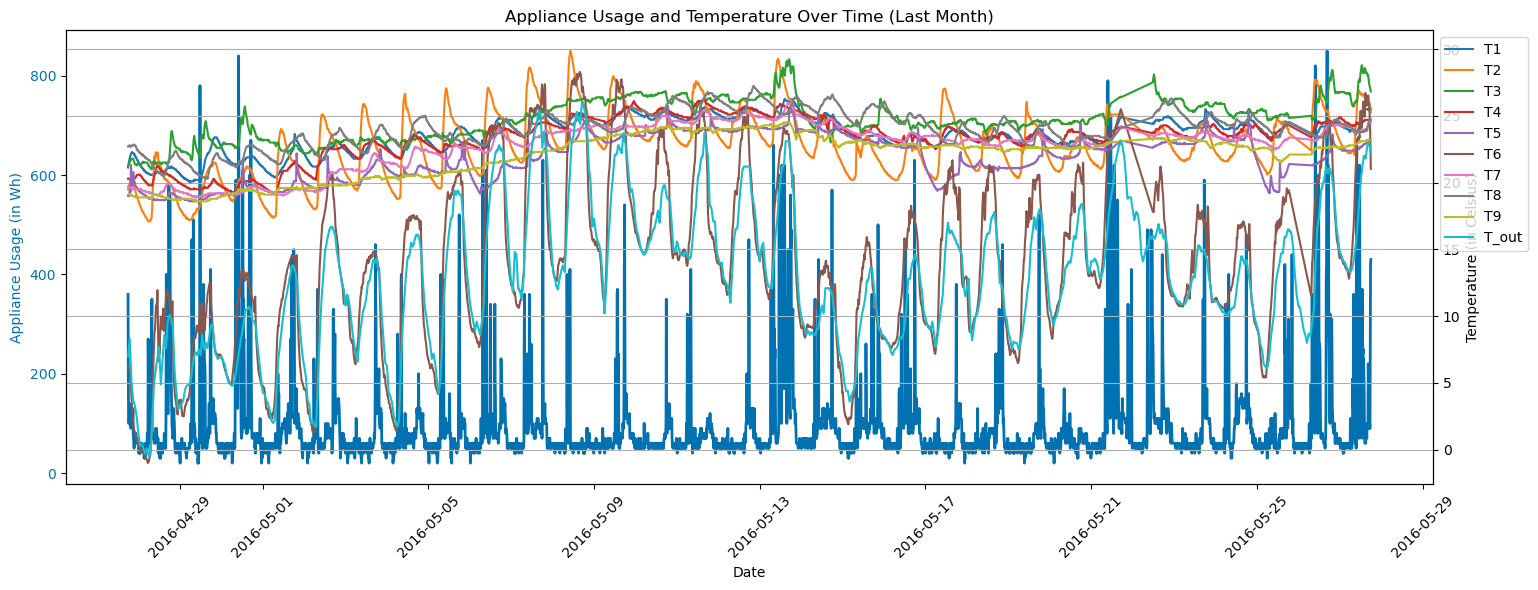

In [19]:
fig, ax1 = plt.subplots(figsize=(15, 6))

df['date'] = pd.to_datetime(df['date'])

last_month = df['date'].max() - pd.DateOffset(months=1)
df_last_month = df[df['date'] >= last_month]

ax1.plot(df_last_month['date'], df_last_month['Appliances'], color='#0072B2', linewidth=2, label='Appliances')
ax1.set_xlabel('Date')
ax1.set_ylabel('Appliance Usage (in Wh)', color='#0072B2')
ax1.tick_params(axis='y', labelcolor='#0072B2')
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()

tempcolumns = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T_out']
for temp in tempcolumns:
    ax2.plot(df_last_month['date'], df_last_month[temp], label=temp)

ax2.set_ylabel('Temperature (in Celsius)')
ax2.tick_params(axis='y')

plt.title('Appliance Usage and Temperature Over Time (Last Month)')
plt.grid(True)

plt.tight_layout()

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Without the T6 and T_out, we can see that temperature of the other rooms spike up when the appliance usage spikes up. Also when we only look appliances T_6 and T_out, we can see that spikes and low points still follow each other, which tells us the hard dependency between this variables, which again, is very self explanatory

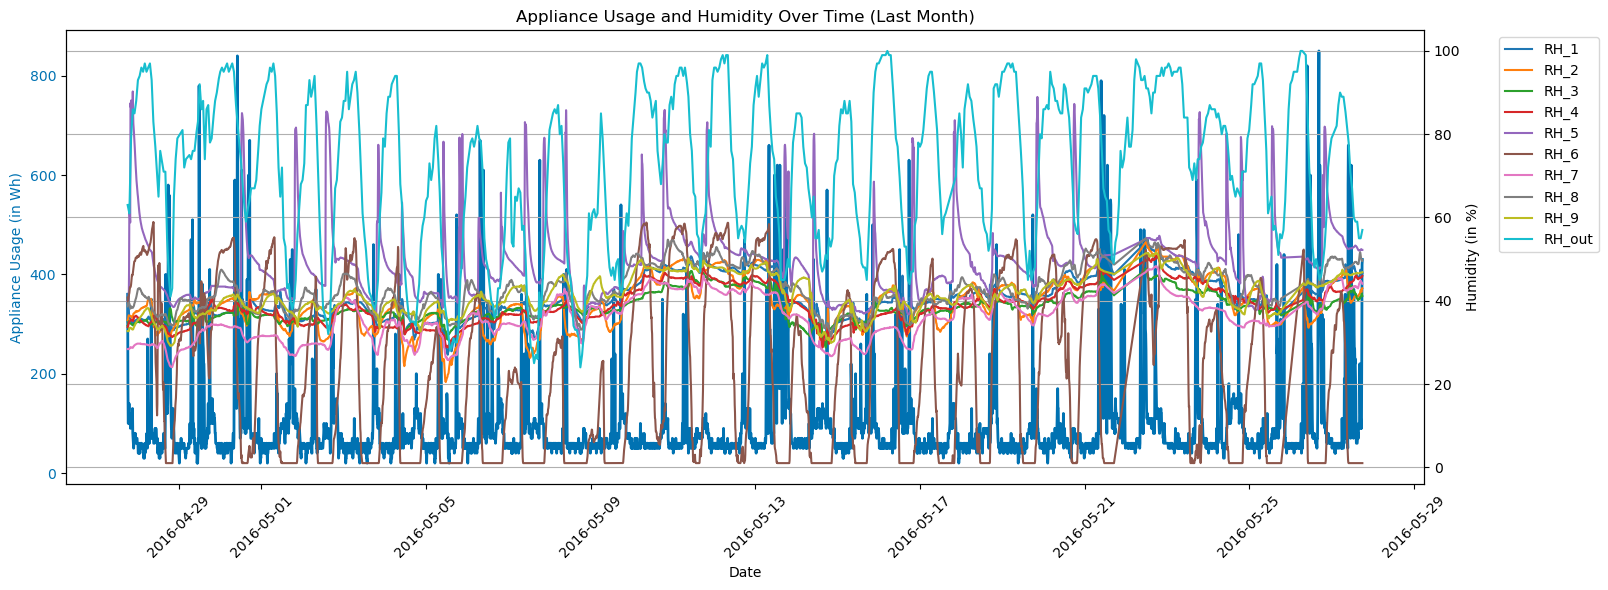

In [21]:
fig, ax1 = plt.subplots(figsize=(15, 6))

df['date'] = pd.to_datetime(df['date'])

last_month = df['date'].max() - pd.DateOffset(months=1)
df_last_month = df[df['date'] >= last_month]

ax1.plot(df_last_month['date'], df_last_month['Appliances'], color='#0072B2', linewidth=2, label='Appliances')
ax1.set_xlabel('Date')
ax1.set_ylabel('Appliance Usage (in Wh)', color='#0072B2')
ax1.tick_params(axis='y', labelcolor='#0072B2')
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()

humiditycolumns = ['RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9', 'RH_out']
for humidity in humiditycolumns:
    ax2.plot(df_last_month['date'], df_last_month[humidity], label=humidity)

ax2.set_ylabel('Humidity (in %)')
ax2.tick_params(axis='y')

# Title and grid
plt.title('Appliance Usage and Humidity Over Time (Last Month)')
plt.grid(True)

plt.tight_layout()

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

So this graph is little bit messed up, but using slicer we can see some patterns on shorter intervals, which gives us clearer picture. So RH_5, which represents bathroom humidity, shows sharp spikes likely due to showering or bathing. These spikes often coincide with increases in appliance usage, though not every appliance usage peak aligns with an RH_5 spike. Meanwhile, all other variables—except RH_6 and RH_out (both representing outdoor humidity)—tend to peak when appliance usage is low or not at its highest

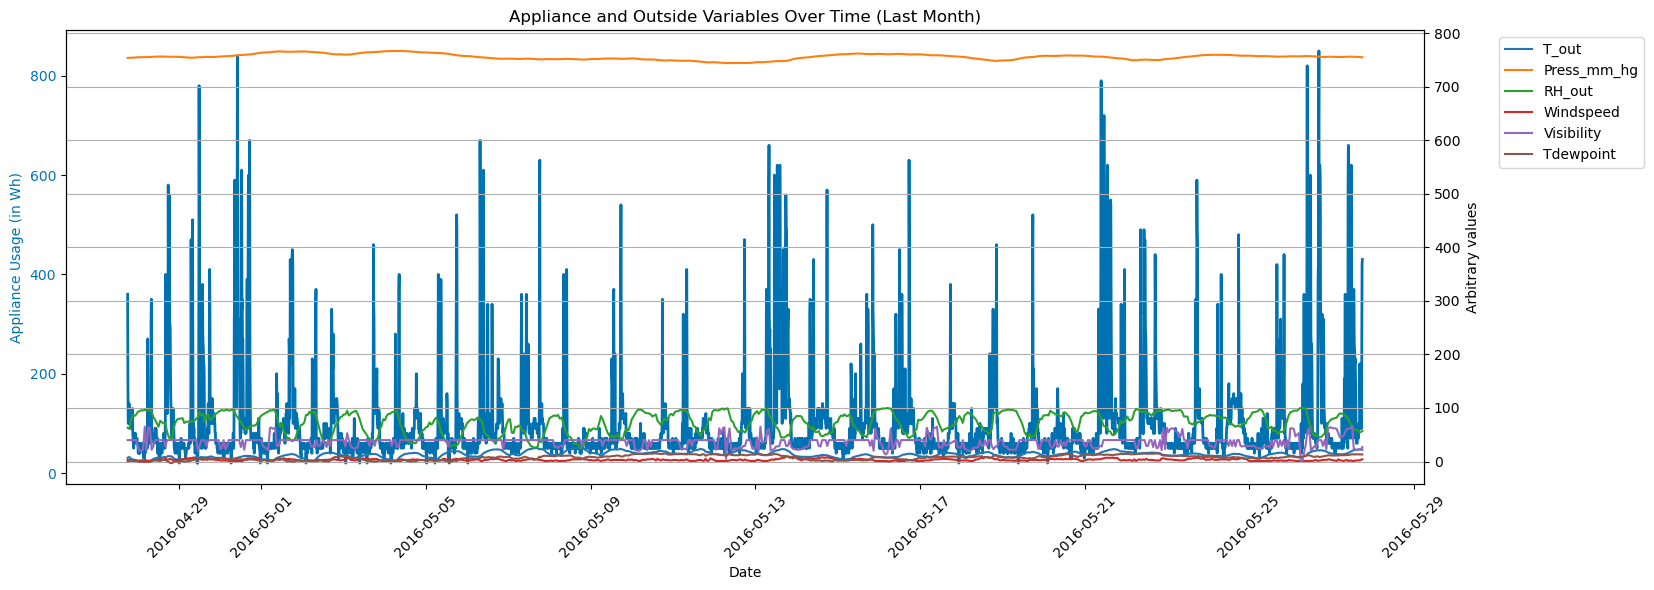

In [23]:
fig, ax1 = plt.subplots(figsize=(15, 6))

df['date'] = pd.to_datetime(df['date'])

last_month = df['date'].max() - pd.DateOffset(months=1)
df_last_month = df[df['date'] >= last_month]

ax1.plot(df_last_month['date'], df_last_month['Appliances'], color='#0072B2', linewidth=2, label='Appliances')
ax1.set_xlabel('Date')
ax1.set_ylabel('Appliance Usage (in Wh)', color='#0072B2')
ax1.tick_params(axis='y', labelcolor='#0072B2')
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()

outside_columns = ['T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint']
for column in outside_columns:
    ax2.plot(df_last_month['date'], df_last_month[column], label=column)

ax2.set_ylabel('Arbitrary values')  
ax2.tick_params(axis='y')

plt.title('Appliance and Outside Variables Over Time (Last Month)')
plt.grid(True)

plt.tight_layout()

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

Outside Temperature and Tdewpoint show a strong correlation. Their small fluctuations likely reflect the day-night cycle—both increase during the day due to sunlight. It is reasonable to assume that household activity also rises during the day, which explains the observed correlation between appliance usage and both temperature and Tdewpoint. Other than this, there are no clear trends or strong correlations between other weather station variables and appliance usage

Now lets do some time series analysis on our target variable only

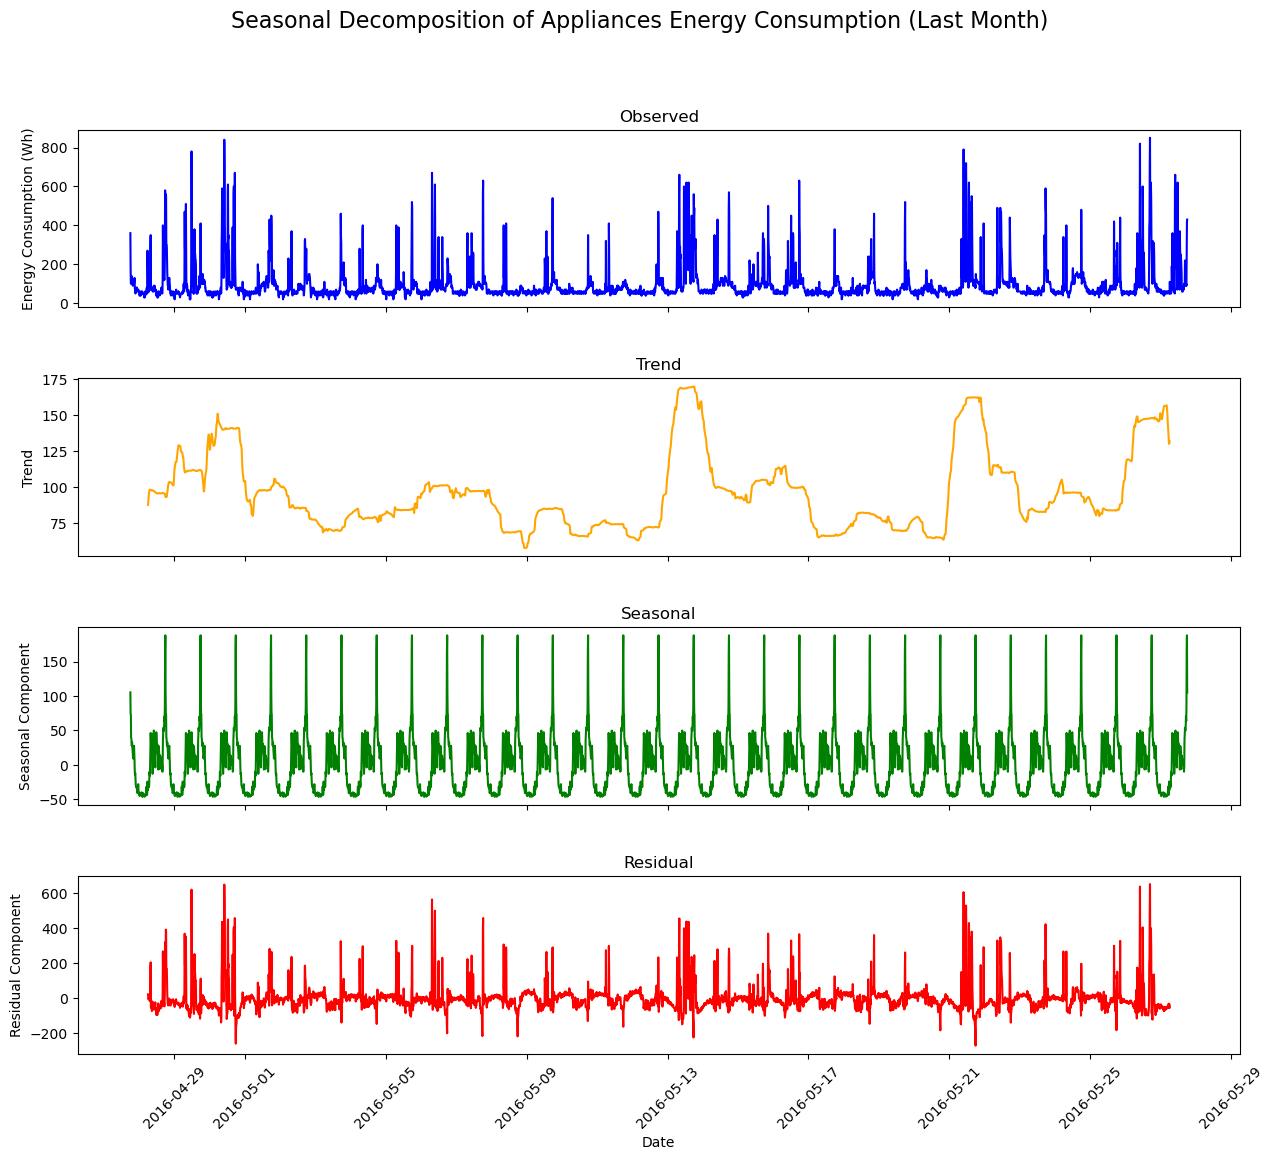

In [26]:
df_decomp = df.copy()
df_decomp['date'] = pd.to_datetime(df_decomp['date'])
df_decomp = df_decomp.set_index('date')

last_month = df_decomp.index.max() - pd.DateOffset(months=1)
df_last_month = df_decomp[df_decomp.index >= last_month]

result = seasonal_decompose(df_last_month['Appliances'], model='additive', period=144)

fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
fig.subplots_adjust(hspace=0.4)

sns.lineplot(x=result.observed.index, y=result.observed, ax=axes[0], color='blue')
axes[0].set_title('Observed')
axes[0].set_ylabel('Energy Consumption (Wh)')

sns.lineplot(x=result.trend.index, y=result.trend, ax=axes[1], color='orange')
axes[1].set_title('Trend')
axes[1].set_ylabel('Trend')

sns.lineplot(x=result.seasonal.index, y=result.seasonal, ax=axes[2], color='green')
axes[2].set_title('Seasonal')
axes[2].set_ylabel('Seasonal Component')

sns.lineplot(x=result.resid.index, y=result.resid, ax=axes[3], color='red')
axes[3].set_title('Residual')
axes[3].set_ylabel('Residual Component')

fig.suptitle('Seasonal Decomposition of Appliances Energy Consumption (Last Month)', fontsize=16)
plt.xticks(rotation=45)
plt.xlabel('Date')

plt.show()

So again, no trend here, but static seasonality between day and night periods

Now it is time to start our baseline model, which I think would be good to be SARIIMA, because many reasons. SARIMA is really simple, which is how baseline model should be, and is really effective for seasonal data as we have right now so it is a good fit in every way

In [29]:
baseline_df = df.copy()
baseline_df['date'] = pd.to_datetime(baseline_df['date'])

baseline_df = baseline_df.set_index('date')

baseline_df = baseline_df.sort_index()

In [30]:
def check_stationarity(series, title):
    result = adfuller(series.dropna())

    print(f"ADF Test for {title}")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")

    if result[1] <= 0.05:
        print("Conclusion: Series is stationary (reject H0)")
        return True
    else:
        print("Conclusion: Series is non-stationary (fail to reject H0)")
        return False
        
is_stationary = check_stationarity(baseline_df['Appliances'], 'Appliances Energy')

if not is_stationary:
    baseline_df['Appliances_diff'] = baseline_df['Appliances'].diff()

    is_diff_stationary = check_stationarity(baseline_df['Appliances_diff'], 'Differenced Appliances Energy')

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=baseline_df.index[1:], y=baseline_df['Appliances_diff'].dropna(),
                             mode='lines', name='Differenced Appliances'))
    fig.update_layout(title='Differenced Appliances Energy Usage',
                      xaxis_title='Timestamp',
                      yaxis_title='Differenced Energy (Wh)',
                      template='plotly_white')
    fig.show()

    d = 1
else:
    d = 0

ADF Test for Appliances Energy
ADF Statistic: -21.61637819803621
p-value: 0.0
Critical Values:
	1%: -3.430681600227742
	5%: -2.8616865555329394
	10%: -2.566848007525354
Conclusion: Series is stationary (reject H0)


In [31]:
baseline_df = baseline_df['Appliances']

In [32]:
train_size = int(len(baseline_df) * 0.8)
train_data = baseline_df[:train_size]
test_data = baseline_df[train_size:]

In [33]:
warnings.filterwarnings("ignore")

order = (1, 1, 1)
seasonal_order = (1, 1, 1, 24)

model = SARIMAX(train_data,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit = model.fit(disp=False, maxiter=50, method='powell')

predictions = model_fit.forecast(steps=len(test_data))

rmse = sqrt(mean_squared_error(test_data, predictions))
mae = mean_absolute_error(test_data, predictions)

mask = test_data != 0
mape = np.mean(np.abs((test_data[mask] - predictions[mask]) / test_data[mask])) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 90.88
MAE: 50.93
MAPE: 55.79%


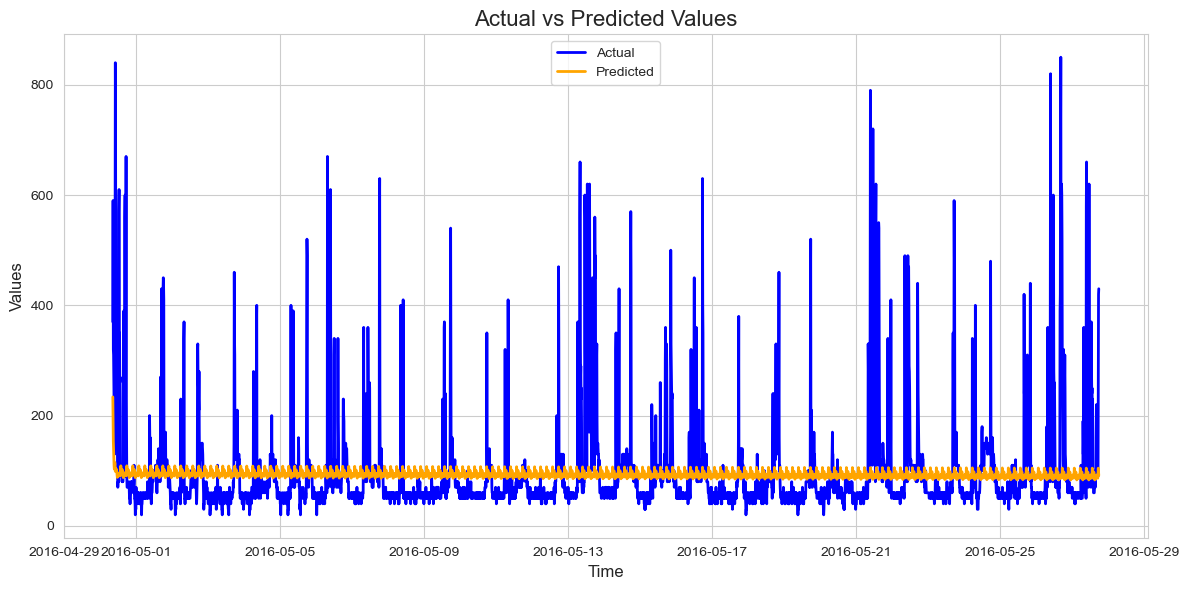

In [34]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

plt.plot(test_data.index, test_data, label='Actual', color='blue', linewidth=2)
plt.plot(test_data.index, predictions, label='Predicted', color='orange', linewidth=2)

plt.title('Actual vs Predicted Values', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

To conclude the results, model captures general pattern but lacks precision, it struggles with accuracy. Could not expect more from just a simple baseline, now we can do the next model of a choice, that will be more advanced and will hopefully catch better non linear patterns

Based on the past experience, I would love to do the feature engineering with some domain knowledge and researches, and I also decided to use XGBoost, because it yielded further better results than ARIMAX in earlier projects, so why should we not use it again

In [37]:
# Lag Features for Target Variable
for lag in [1, 2, 3, 6, 12, 24]:
    df[f'Appliances_lag_{lag}'] = df['Appliances'].shift(lag)
    df[f'lights_lag_{lag}'] = df['lights'].shift(lag)

# Time-based features
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Moving averages for temperature and humidity
for window in [6, 12, 24, 48]:
    df[f'T_out_MA_{window}'] = df['T_out'].rolling(window=window).mean()
    df[f'T1_MA_{window}'] = df['T1'].rolling(window=window).mean()

    df[f'RH_out_MA_{window}'] = df['RH_out'].rolling(window=window).mean()
    df[f'RH_1_MA_{window}'] = df['RH_1'].rolling(window=window).mean()

    df[f'Appliances_MA_{window}'] = df['Appliances'].rolling(window=window).mean()
    df[f'Appliances_std_{window}'] = df['Appliances'].rolling(window=window).std()

# Temperature differences (indoor vs outdoor)
for i in range(1, 10):
    df[f'T{i}_minus_Tout'] = df[f'T{i}'] - df['T_out']
    df[f'RH{i}_minus_RHout'] = df[f'RH_{i}'] - df['RH_out']

# Day/night indicator (assuming 7:00-19:00 is day)
df['is_daytime'] = ((df['hour'] >= 7) & (df['hour'] < 19)).astype(int)

# Weekend indicator
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

In [38]:
X = df.drop(['date', 'Appliances'], axis=1)
y = df['Appliances']

train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [39]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

print("Starting hyperparameter tuning...")
grid_search.fit(X_train, y_train)

print("\nBest parameters found by GridSearchCV:")
print(grid_search.best_params_)
print(f"Best RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1))) * 100
r2 = r2_score(y_test, y_pred)

print(f"\nTuned XGBoost Performance:")
print(f"MAE: {mae:.2f} Wh")
print(f"RMSE: {rmse:.2f} Wh")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Starting hyperparameter tuning...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best parameters found by GridSearchCV:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best RMSE: 49.4669

Tuned XGBoost Performance:
MAE: 23.90 Wh
RMSE: 45.71 Wh
MAPE: 24.82%
R²: 0.7479


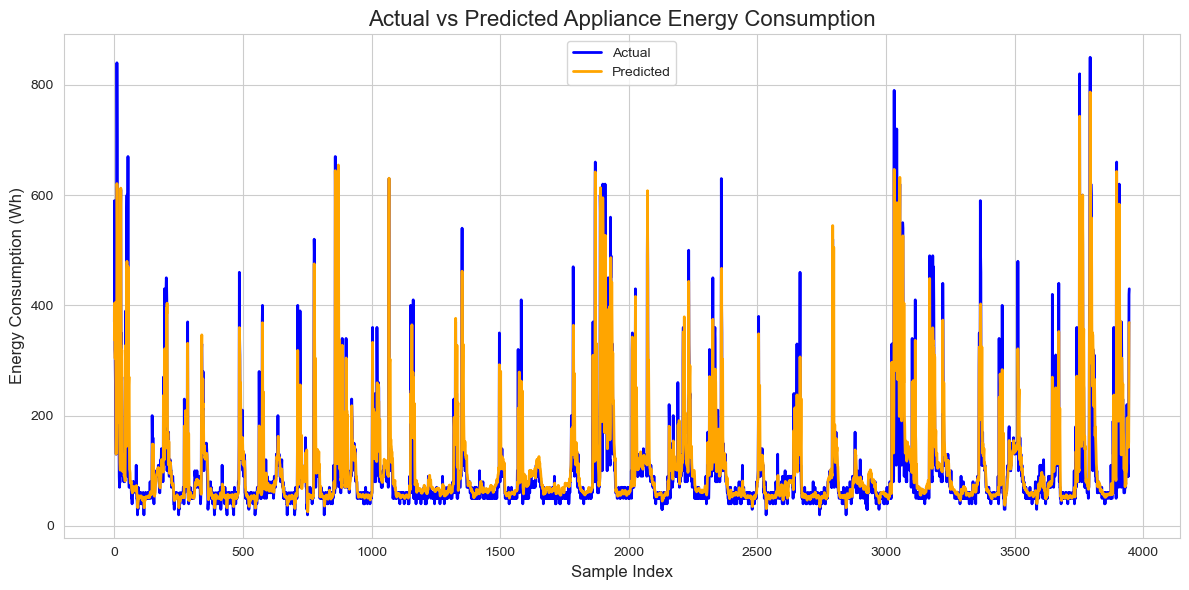

In [40]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

plt.plot(y_test.values, label='Actual', color='blue', linewidth=2)
plt.plot(y_pred, label='Predicted', color='orange', linewidth=2)

plt.title('Actual vs Predicted Appliance Energy Consumption', fontsize=16)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Energy Consumption (Wh)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

So we have results from the XGBoost as well, lets now do the final comparison of our advanced and baseline models:

**SARIMA(baseline)**:
- RMSE: 90.88
- MAE: 50.93
- MAPE: 55.79%


**XGBoost(main)**:
- MAE: 23.24
- RMSE: 44.30
- MAPE: 24.39%

XGBoost outperforms SARIMA in every metric, with over 50% better results. It handles complex patterns, non-linearities, and outliers much better. While SARIMA is good for basic time series trends, XGBoost is clearly more accurate and practical for predicting appliance energy when more features are available.
